In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. 데이터 불러오기
df = pd.read_parquet("open/train/잔액정보_with_segment.parquet")

# 2. 범주형 컬럼을 수치형으로 변환
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 3. Segment도 숫자로 인코딩
df["Segment_code"] = df["Segment"]

# 4. 수치형 컬럼 목록 (Segment_code 제외)
numeric_cols = df.select_dtypes(include=["number"]).columns.drop("Segment_code")

# 5. 컬럼별 상관계수 계산 (결측치 제외)
corr_dict = {}
for col in numeric_cols:
    temp_df = df[[col, "Segment_code"]].dropna()
    if temp_df.shape[0] > 1:  # 데이터가 2행 이상 있어야 상관계수 계산 가능
        corr = temp_df.corr().iloc[0, 1]
        corr_dict[col] = corr

# 6. 정렬된 시리즈로 변환
corr_with_segment = pd.Series(corr_dict).sort_values(ascending=False)

# 7. 출력
print("📊 Segment와의 상관계수 (결측치 제외, 내림차순 정렬):")
print(corr_with_segment)


📊 Segment와의 상관계수 (결측치 제외, 내림차순 정렬):
Segment              1.000000
연체일수_최근              0.041942
ID                   0.001218
연체잔액_대환론_B0M         0.000731
매각잔액_B1M             0.000298
                       ...   
RV잔액이월횟수_R3M              NaN
연체잔액_일시불_해외_B0M           NaN
연체잔액_RV일시불_해외_B0M         NaN
연체잔액_할부_해외_B0M            NaN
연체잔액_CA_해외_B0M            NaN
Length: 83, dtype: float64


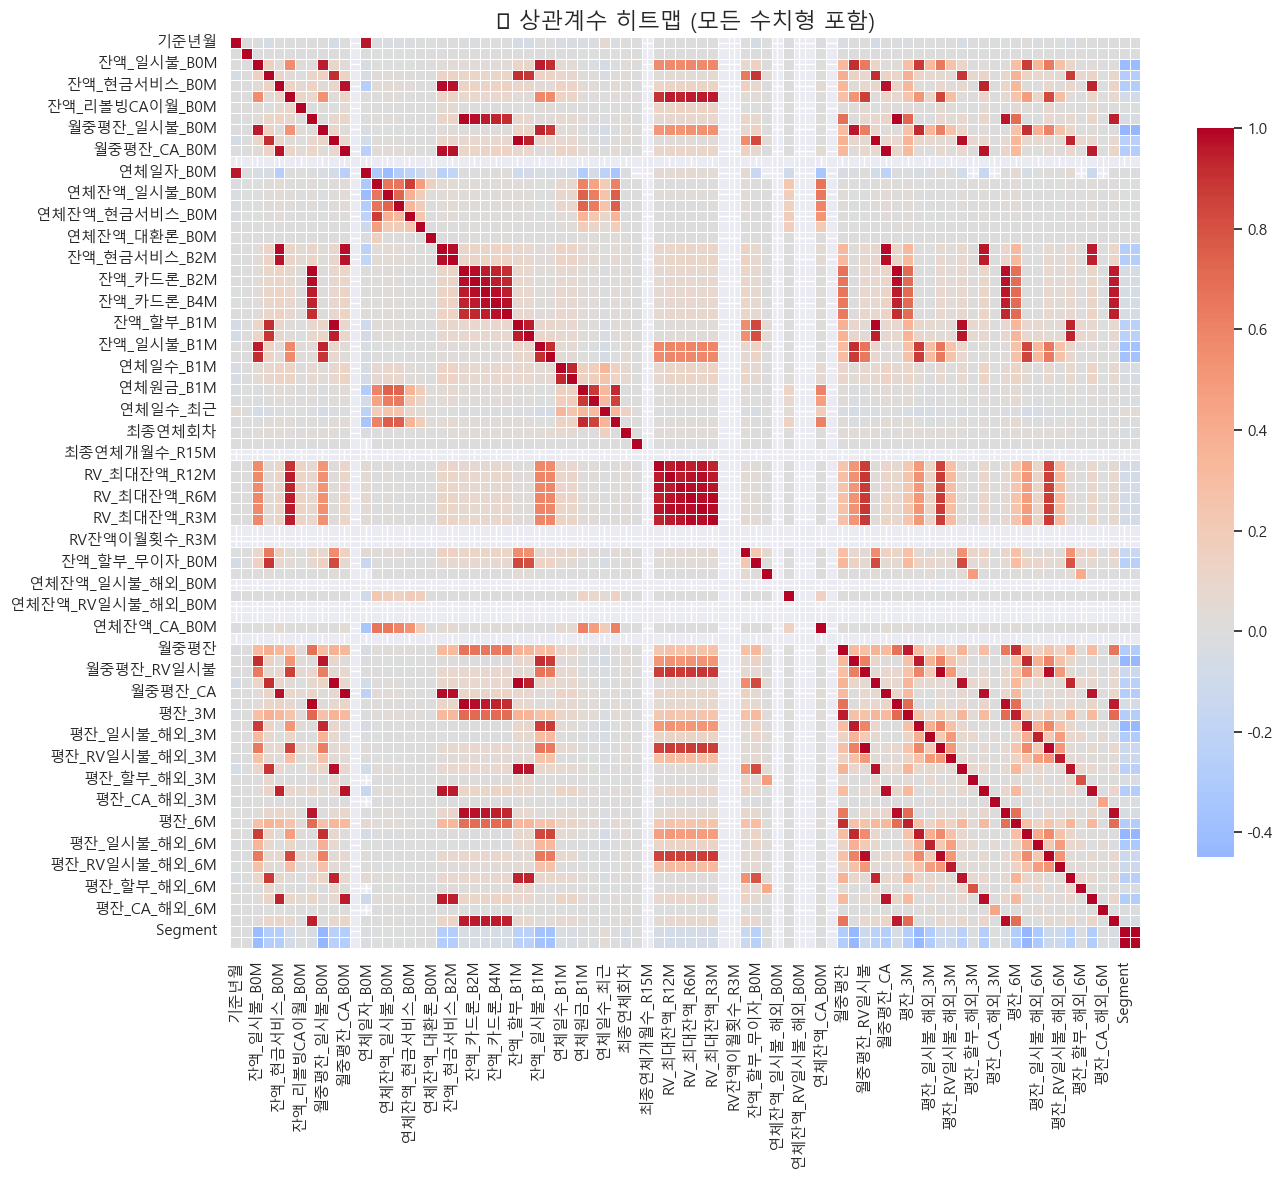

In [3]:
corr_matrix = df.corr(numeric_only=True)

# 5. 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,        # 숫자 생략 (많은 경우에는 복잡)
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title("📊 상관계수 히트맵 (모든 수치형 포함)", fontsize=16)
plt.tight_layout()
plt.show()

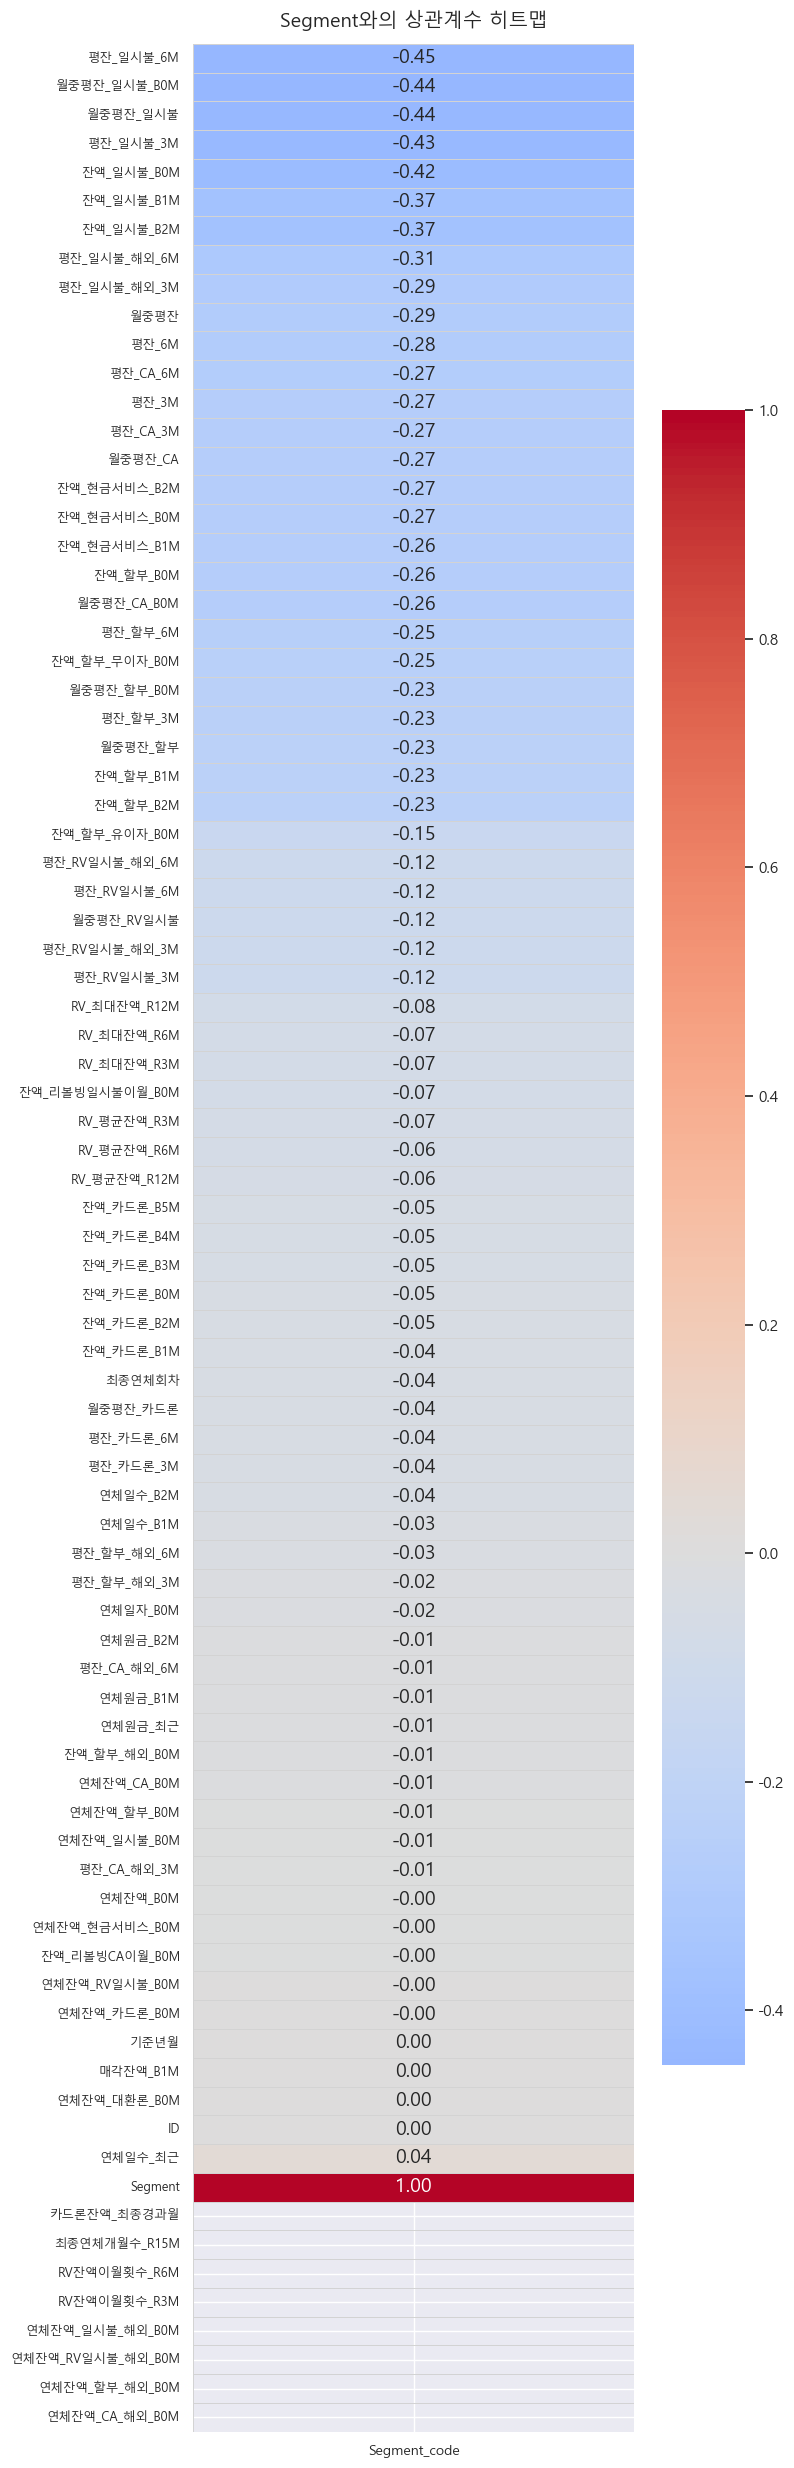

In [4]:
# 범주형 → 수치형으로 변환
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Segment 인코딩
df["Segment_code"] = df["Segment"]

# 상관계수 계산
corr = df.corr(numeric_only=True)

# Segment_code와 다른 컬럼의 상관계수만 추출
segment_corr = corr["Segment_code"].drop("Segment_code").sort_values()

# 히트맵 시각화
plt.figure(figsize=(8, len(segment_corr) * 0.3))  # 길이에 따라 자동조절
sns.heatmap(
    segment_corr.to_frame(), 
    annot=True, fmt=".2f", cmap="coolwarm", center=0, 
    cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor='lightgray'
)

plt.title("Segment와의 상관계수 히트맵", fontsize=14, pad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9, rotation=0)
plt.tight_layout()
plt.show()

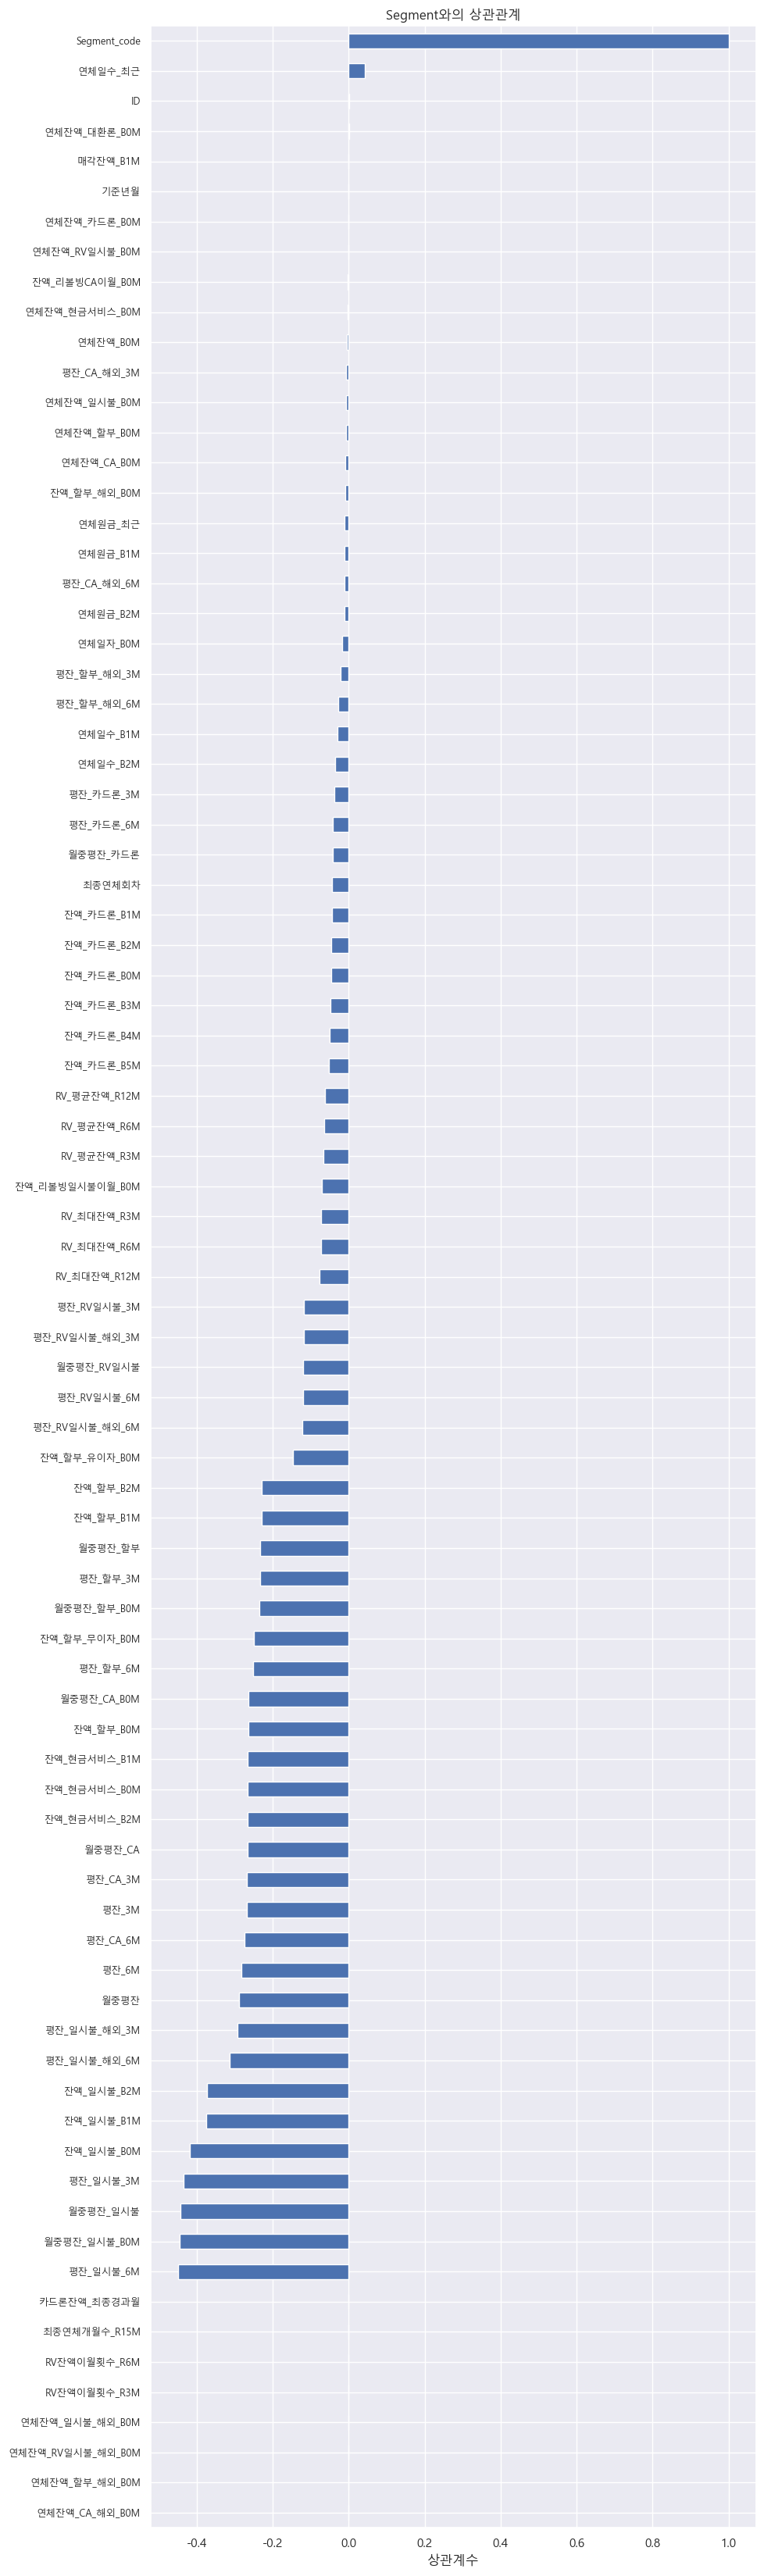

In [5]:
# Segment와의 상관관계만 추출
segment_corr = corr['Segment'].drop('Segment').sort_values(ascending=False)

# 시각화 (막대그래프)
plt.figure(figsize=(10, len(segment_corr) * 0.4))
segment_corr.plot(kind='barh')
plt.title("Segment와의 상관관계")
plt.xlabel("상관계수")
plt.yticks(fontsize=9)  # y축 텍스트 크기 조정
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


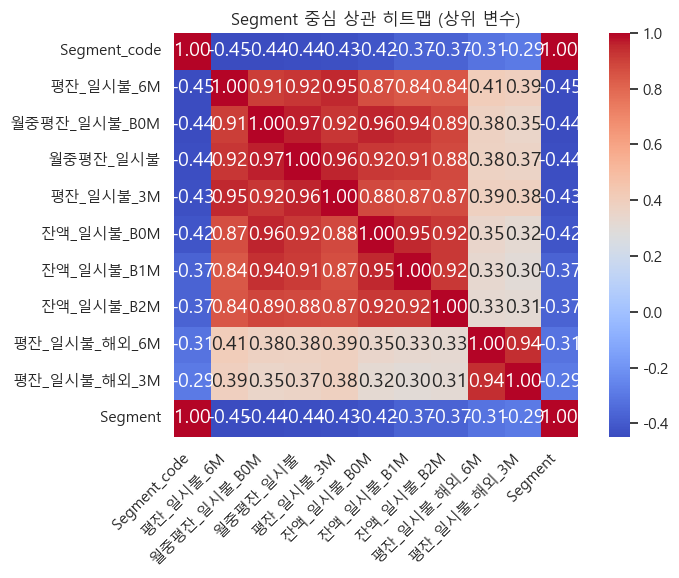

In [6]:
top_features = corr['Segment'].abs().sort_values(ascending=False).drop('Segment').head(10).index.tolist()
selected_corr = corr.loc[top_features + ['Segment'], top_features + ['Segment']]

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(selected_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Segment 중심 상관 히트맵 (상위 변수)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# 결측치 제거

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. 데이터 불러오기
df = pd.read_parquet("open/train/잔액정보_with_segment.parquet")

# 생략 없이 모든 값 출력 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 2. 범주형 → 수치형으로 변환
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 3. Segment를 수치형으로 변환 (혹시 문자일 수도 있으므로)
if df["Segment"].dtype == 'object' or df["Segment"].dtype.name == 'category':
    df["Segment"] = LabelEncoder().fit_transform(df["Segment"].astype(str))

# 4. 수치형 컬럼 리스트 (Segment 제외)
numeric_cols = df.select_dtypes(include="number").columns.drop("Segment")

# 5. 각 컬럼에서 해당 컬럼의 결측치만 제거하고 Segment와 상관계수 계산
corr_dict = {}
for col in numeric_cols:
    valid_idx = df[col].notna()
    if valid_idx.sum() >= 2:
        corr_val = df.loc[valid_idx, col].corr(df.loc[valid_idx, "Segment"])
        corr_dict[col] = corr_val

# 6. 결과 정리
segment_corr1 = pd.Series(corr_dict).sort_values(ascending=False)

# 7. 출력
print("📊 Segment와의 상관계수 (각 변수 결측치 제거 기준):")
print(segment_corr1)


📊 Segment와의 상관계수 (각 변수 결측치 제거 기준):
연체일수_최근              4.194225e-02
ID                   1.218077e-03
연체잔액_대환론_B0M         7.311299e-04
매각잔액_B1M             2.984966e-04
기준년월                 8.217349e-19
연체잔액_카드론_B0M        -2.469589e-04
연체잔액_RV일시불_B0M      -5.534963e-04
잔액_리볼빙CA이월_B0M      -1.597595e-03
연체잔액_현금서비스_B0M      -2.996266e-03
연체잔액_B0M            -4.796210e-03
평잔_CA_해외_3M         -5.996236e-03
연체잔액_일시불_B0M        -6.421011e-03
연체잔액_할부_B0M         -6.645312e-03
연체잔액_CA_B0M         -7.851869e-03
잔액_할부_해외_B0M        -8.217860e-03
연체원금_최근             -1.002700e-02
연체원금_B1M            -1.143670e-02
평잔_CA_해외_6M         -1.169262e-02
연체원금_B2M            -1.171650e-02
연체일자_B0M            -1.670460e-02
평잔_할부_해외_3M         -2.039534e-02
평잔_할부_해외_6M         -2.745745e-02
연체일수_B1M            -2.825491e-02
연체일수_B2M            -3.523933e-02
평잔_카드론_3M           -3.764922e-02
평잔_카드론_6M           -4.205892e-02
월중평잔_카드론            -4.212317e-02
최종연체회차              -4.351491e-02
잔액_카드론_B1M   

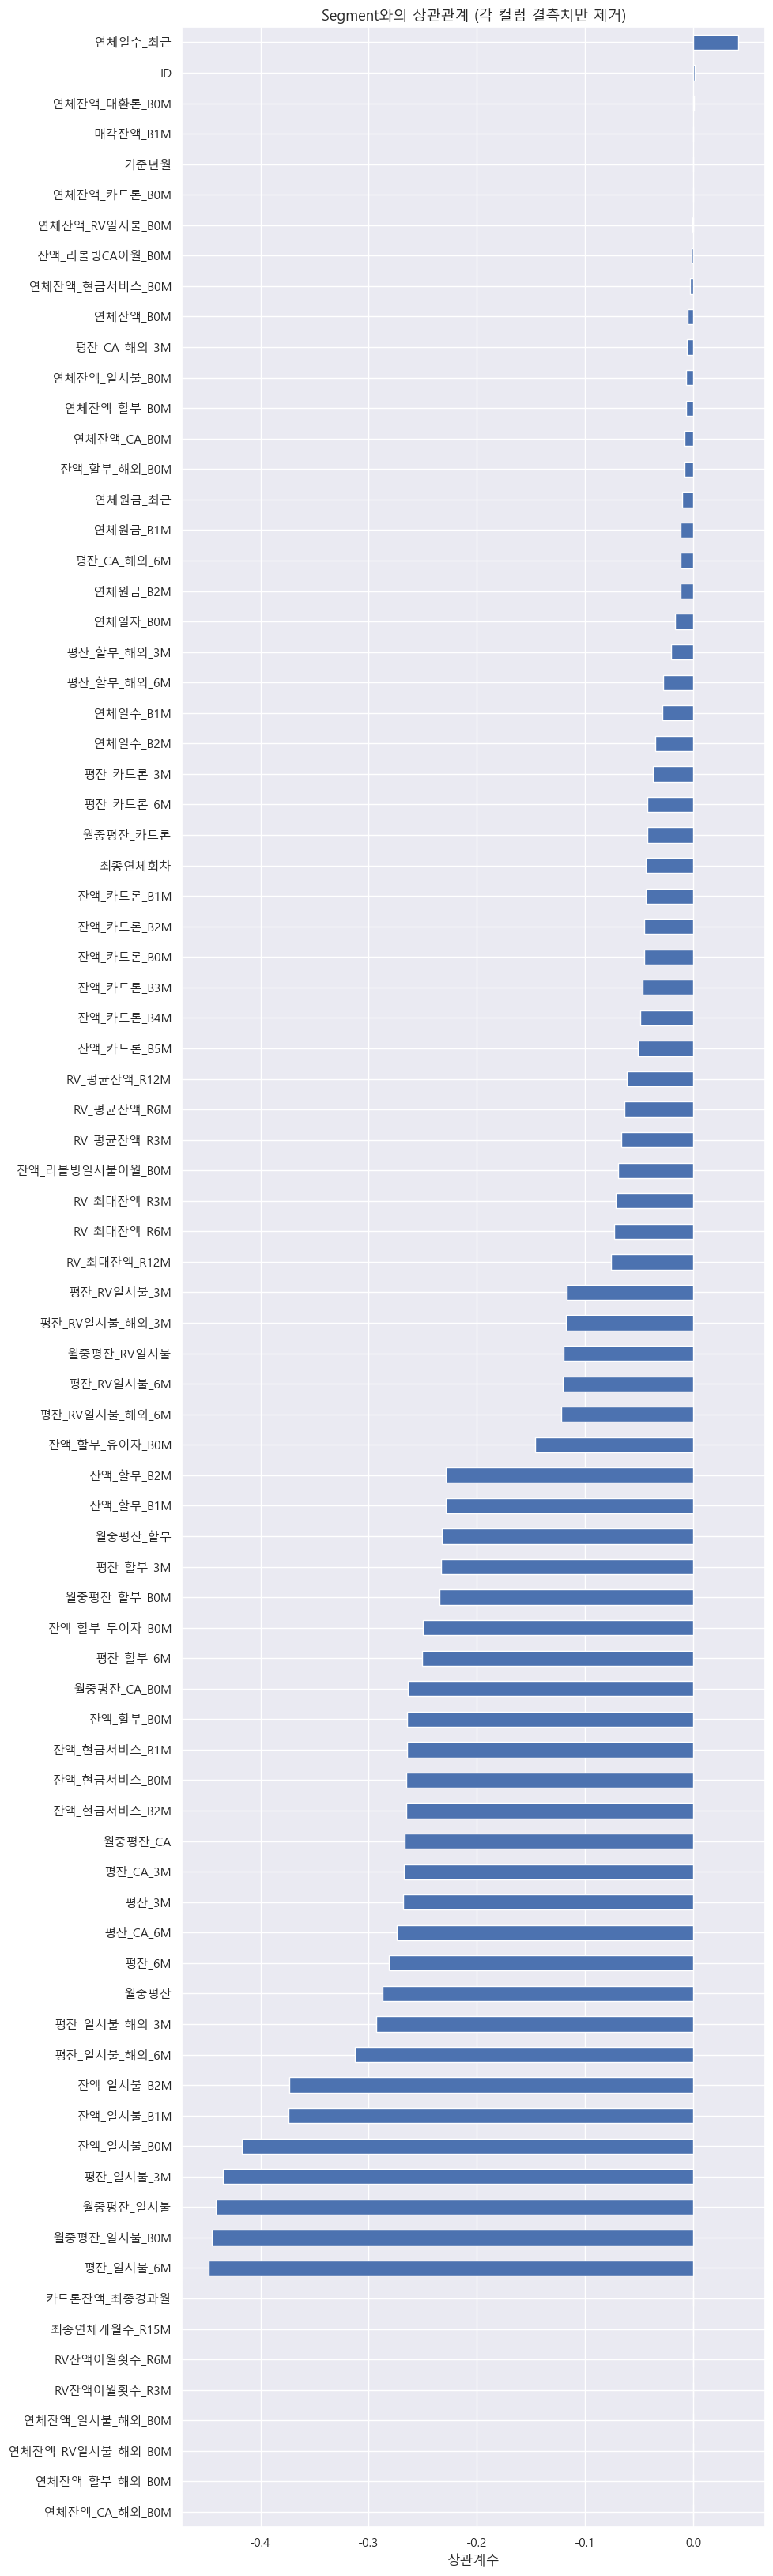

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, len(segment_corr1) * 0.4))
segment_corr1.plot(kind='barh')
plt.title("Segment와의 상관관계 (각 컬럼 결측치만 제거)", fontsize=13)
plt.xlabel("상관계수")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


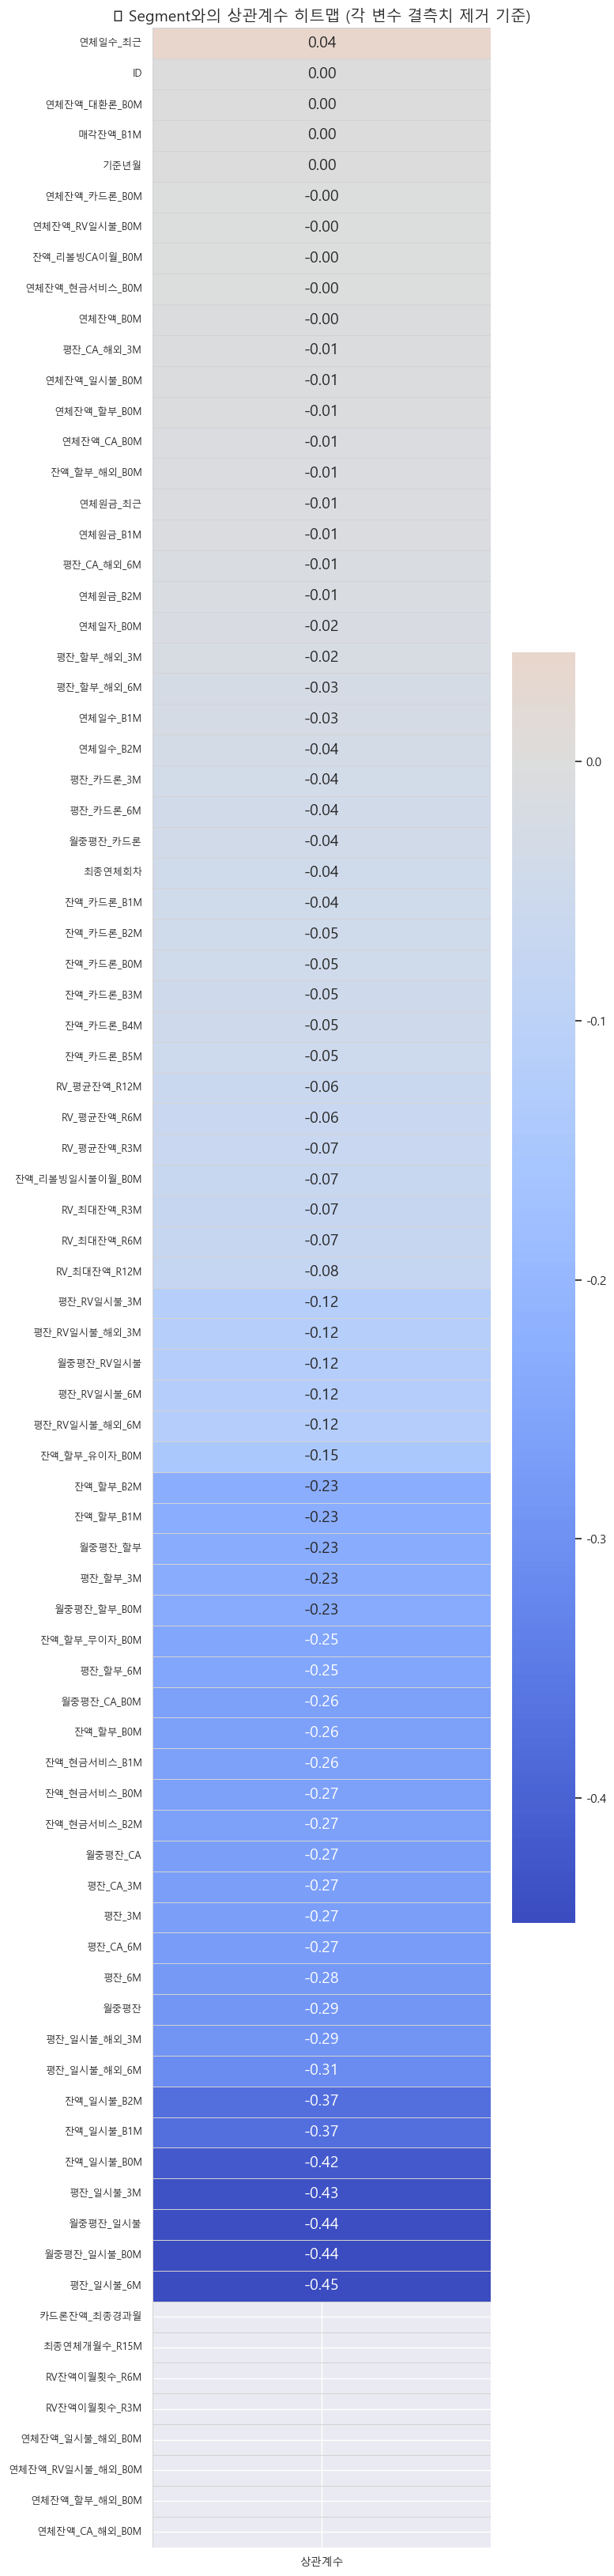

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히트맵 시각화
plt.figure(figsize=(8, len(segment_corr1) * 0.4))
sns.heatmap(
    segment_corr1.to_frame(name="상관계수"),
    annot=True, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=0.5, linecolor="lightgray",
    cbar_kws={"shrink": 0.8}
)

plt.title("📊 Segment와의 상관계수 히트맵 (각 변수 결측치 제거 기준)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9, rotation=0)
plt.tight_layout()
plt.show()


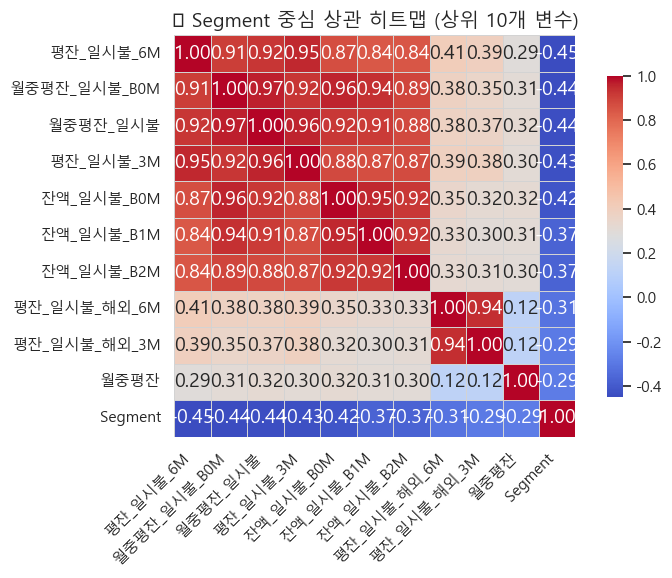

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 1. 데이터 불러오기
df = pd.read_parquet("open/train/잔액정보_with_segment.parquet")

# 2. 범주형 → 수치형으로 변환
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 3. Segment 인코딩
df["Segment"] = LabelEncoder().fit_transform(df["Segment"].astype(str))

# 4. 수치형 컬럼만 추출
numeric_cols = df.select_dtypes(include="number").columns.tolist()

# 5. 상관계수 행렬 초기화
corr_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols, dtype=float)

# 6. 각 변수쌍마다 결측치 제거 후 상관계수 계산
for col1 in numeric_cols:
    for col2 in numeric_cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0  # 자기 자신과는 상관계수 1
        else:
            temp = df[[col1, col2]].dropna()
            if len(temp) >= 2:
                corr_val = temp[col1].corr(temp[col2])
                corr_matrix.loc[col1, col2] = corr_val

# 7. Segment 기준 상관 절댓값 상위 10개 변수 추출
top_features = corr_matrix["Segment"].abs().sort_values(ascending=False).drop("Segment").head(10).index.tolist()

# 8. Segment 포함 상관행렬 추출
selected_corr = corr_matrix.loc[top_features + ["Segment"], top_features + ["Segment"]]

# 9. 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    selected_corr.astype(float),
    annot=True, fmt=".2f", cmap="coolwarm", square=True,
    linewidths=0.5, linecolor="lightgray", cbar_kws={"shrink": 0.8}
)
plt.title("📊 Segment 중심 상관 히트맵 (상위 10개 변수)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
# 예: corr_with_segment 라는 Series가 있다고 가정
# NaN 제외하고 절댓값 기준으로 중앙값 계산

median_corr = segment_corr1.dropna().abs().median()

print("Segment와의 상관계수 중앙값:", median_corr)


Segment와의 상관계수 중앙값: 0.0681739585755573


In [20]:
# 상관계수 Series가 corr_with_segment 라고 가정
# 절댓값이 0.3 이상인 컬럼만 추출
selected_features = segment_corr1[abs(segment_corr1) >= 0.3].index.tolist()

# Segment 컬럼도 포함해서 저장할 컬럼 리스트 만들기
cols_to_save = selected_features + ['Segment']

# 해당 컬럼들만 포함된 데이터프레임 만들기
filtered_df = df[cols_to_save]

# CSV로 저장
filtered_df.to_csv("05.잔액정보_컬럼선택.csv", index=False, encoding="utf-8-sig")


In [29]:
df1 = pd.read_csv("05.잔액정보_컬럼선택.csv")
display(df1)

In [1]:
import pandas as pd
from IPython.display import display

# 1. 합쳐진 파일 불러오기
df = pd.read_parquet("open/train/잔액정보_with_segment.parquet")

# 2. Segment 컬럼 자동 탐색 및 숫자형 변환
segment_col_candidates = [col for col in df.columns if 'segment' in col.lower()]
print("사용 가능한 Segment 컬럼 후보:", segment_col_candidates)
segment_col = segment_col_candidates[-1]

if df[segment_col].dtype == 'object':
    df[segment_col] = df[segment_col].astype('category').cat.codes

# 3. 숫자형 컬럼만 추출 (Segment 제외)
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != segment_col]

# 4. 결측치 제거 및 std=0 컬럼 제거
clean_df = df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]
numeric_cols = [col for col in numeric_cols if col in clean_df.columns]

# 5. 결측치 수 계산
missing_dict = {
    col: df[col].isnull().sum()
    for col in numeric_cols
}

# 6. 이상치 수 계산 (IQR 기준)
outlier_dict = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_dict[col] = outliers

# 7. 상관계수 계산 (Segment 기준)
corr_dict = {
    col: clean_df[segment_col].corr(clean_df[col])
    for col in numeric_cols
}

# 8. 결과 정리
corr_df = pd.DataFrame({
    '컬럼명': list(corr_dict.keys()),
    '상관계수': list(corr_dict.values()),
    '결측치 수': [missing_dict[col] for col in corr_dict.keys()],
    '이상치 수': [outlier_dict[col] for col in corr_dict.keys()]
})

corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)

# 9. 시각화 출력
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(styled)


사용 가능한 Segment 컬럼 후보: ['Segment']


,컬럼명,상관계수,결측치 수,이상치 수
65,평잔_CA_6M,-0.390006,0,236557
57,평잔_CA_3M,-0.352062,0,194560
18,잔액_현금서비스_B2M,-0.317209,0,128289
49,월중평잔_CA,-0.306252,0,146736
9,월중평잔_CA_B0M,-0.292100,0,144989
17,잔액_현금서비스_B1M,-0.276856,0,125813
3,잔액_현금서비스_B0M,-0.259225,0,118446
59,평잔_6M,-0.156569,0,250711
60,평잔_일시불_6M,-0.152588,0,203731
30,연체원금_B1M,-0.145833,0,11560
